In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import matplotlib as mpl

In [3]:
%matplotlib inline

In [4]:
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [5]:
# build 3D data set
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [27]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

## Manual PCA

In [6]:
# use numpy to all princial compenets of training set
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

# extract two PCAs
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [7]:
# create trainging set matrix X
m, n = X.shape 

S = np.zeros(X_centered.shape) # center the data outside of SKLearn
S[:n, :n] = np.diag(s)

In [8]:
# compute the dot product of training set matrix X
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [9]:
# Porject training set onto plane defined by PCAs
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2) 

PCA assumes that the dataset is centered around the origin. SKLearn's PCA classes take acare of centering the data for you. PCA outside will require us to center the data.

In [10]:
X2D_using_svd = X2D

## PCA with SKLearn

In [11]:
# or we can do all of this using SKLearn
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

# can access PCAs using compenets_variable

# Explained Variance Ratio
explained_variance_ratio_ variable of each principal component indicates the proportion of the data's variance that lies along the axis of each PC

In [12]:
pca.explained_variance_

array([0.77830975, 0.1351726 ])

# Number of Dimensions
It is preferable to choose the number of dimenssions that add up to a suffciently large portion of the variance (say 95%). Unless you are reducing for visualziation, then you want to use 2 or 3 dimensions. 

In [13]:
# indiacate the ratio to be preserved with n_compnets
pca = PCA(n_components = 0.95) # preserve 95% of variance
X_reduced = pca.fit_transform(X)

## PCA for Compression
Using PCA for dimensionarlity reduction and compressing the dataset

In [14]:
# importing data set 
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)

In [15]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [16]:
# use pca to preserve 95% of variance
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [17]:
d

154

Each instance has 154 features, instead of the 784 features that we started with. This means the data set has shrunk to 20% of its origional size. We can go the other way, but it will not be perfect, our projection lost some of the data. The mean squared distance between the origional data and the reconstructed data is called th reconstruction error. Basically it is a metric for loss in image quality. 

In [18]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [19]:
pca.n_components_

154

In [20]:
np.sum(pca.explained_variance_ratio_)

0.9503684424557437

In [21]:
# reconstructing the data
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [22]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5,1,'Compressed')

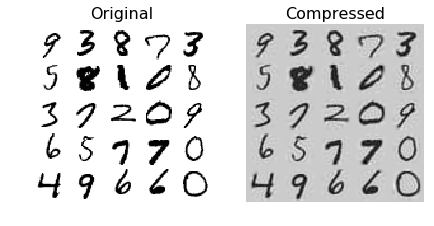

In [23]:
# as we can see we lost all of the white pixels
# now there is some loss in image quality
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

## Incremental PCA
PCA requires the whole training set to fit in memory. we can use Incremental PCA (IPCA) to split the training data into batchs

In [24]:
# splitting MNST data into 100 mini batches
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components = 154)

for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

We can use numpy's 'memmap' class which allows us to manipulate a large array stored in a binary file on disk. The class loads only the data it needs in memory when it needs it. This keeps the memory usage under control. See page 219 for more details.

## Kernel PCA
We can use the Kernel Trick, mapping instances into a very high-demnsional space which enables nonlinear classification abd regression with SVMs. 

In [25]:
# create swiss roll data
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

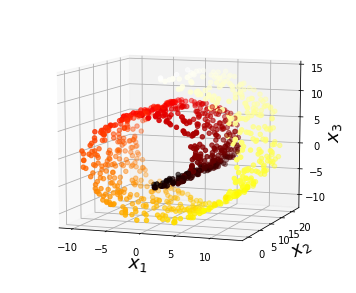

In [28]:
# plot swiss roll
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

In [29]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel = "rbf", gamma = 0.04)
X_reduced = rbf_pca.fit_transform(X)

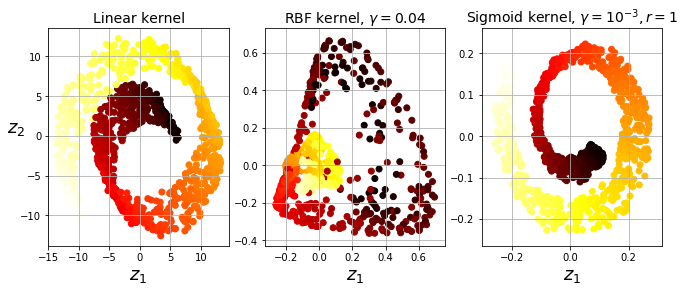

In [30]:
# reducing the swiss roll to a linear, RBF, and Sigmoid
lin_pca = KernelPCA(n_components = 2, kernel ="linear", fit_inverse_transform = True) #linear
rbf_pca = KernelPCA(n_components = 2, kernel ="rbf", gamma = 0.0433, fit_inverse_transform = True) #RBF
sig_pca = KernelPCA(n_components = 2, kernel ="sigmoid", gamma = 0.001, coef0 = 1, fit_inverse_transform = True) #sigmoid

y = t > 6.9

#plotting
plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

Kernel PCA is an unsupervized learning algorithm meaning that there no obvious performance measure. PCA is usually one of our preprocessing steps. We can use kPCA for dimensioality reduction, then we can use grid search to select the best kernel and hypers which lead to the best preformance. 

## Selecting a Kernel and Tuning Hypers

In [34]:
# gridsearch for Logit using kPCA 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
#pipeline the workflow
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components = 2)),
        ("log_reg", LogisticRegression(solver = "liblinear"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv = 3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='linear',
     kernel_params=None, max_iter=None, n_components=2, n_jobs=None,
     random_state=None, remove_zero_eig=False, tol=0)), ('log_reg', LogisticRe...ty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'kpca__gamma': array([0.03   , 0.03222, 0.03444, 0.03667, 0.03889, 0.04111, 0.04333,
       0.04556, 0.04778, 0.05   ]), 'kpca__kernel': ['rbf', 'sigmoid']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [35]:
# best params
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


# Local Linear Embedding
LLE measured how each training instance linearly relates to its closest neighbors, and then looking for a low-dimensional representation of the training set where these local relationships are best preserved

In [36]:
# unroll the swiss using LLE
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components = 2, n_neighbors = 10)
X_reduced = lle.fit_transform(X)

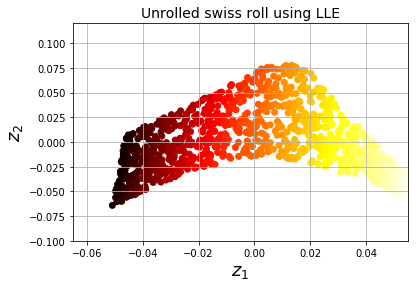

In [37]:
# plot
plt.title("Unrolled swiss roll using LLE", fontsize = 14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c = t, cmap = plt.cm.hot)
plt.xlabel("$z_1$", fontsize = 18)
plt.ylabel("$z_2$", fontsize = 18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

# MDS, Isomap and t-SNE

MultiDimensional Scaling (MDS) reduces while tryong to perserve the distances between instances

In [38]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

Isomap creates a graph by connecting each instance to its nearest neighbors then reduces by trying to perserve geodesic distances

In [40]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

t-Distributed Stocastic Neighbor Embedding reduces while trying to keep simliar instances close and dissimilar apart. Mostly used for visualization, looking for clusters in high-demensions

In [41]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

Linear Discriminant Analysis is a classification algorightm. During training it learns the most discrimitive axes between classes which can be used to define a hyperplane onto which to project the data

In [42]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


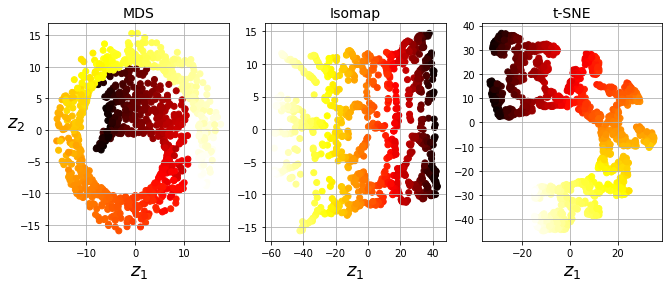

In [44]:
# plot to compare
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()